In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

from auxiliary.auxiliary import (simulate_data, get_results_regression, process_results, get_results_local_regression, 
                                process_results_local)

# Stacking/ Jackknife Model Averaging and its Use in Regression Discontinuity Design
---

## Introduction
---

A common occurrence in data-driven Economics is that the researcher faces uncertainty about several facets of a statistical model as well as the results from its calibration. While the uncertainty in the parameter estimates of a model is typically reported by showing at least the standard deviation of the parameter estimates, it is not common practice in Economics to discuss the implications of uncertainty about the specific form of the statistical model. It is rather common to select one model among several competing models (maybe using some model selection techniques) from that on pretending that it is the true one while performing some robustness checks using other model specifications (Moral-Benito (2015)). 

Fletcher (2019) argues that the typical problem with this negligence of remaining model uncertainty is that parameter estimates might be biased and uncertainty is underestimated. This approach yields confidence intervals of the estimated parameters that are too optimistic in the sense that the true coverage probability is below its nominal level when not accounting for this uncertainty. This might cause the resulting inference to be seriously flawed. This aspect is a major reason why model averaging might be useful in Economics. Model averaging takes information from all competing models into account and therefore explicitly includes model uncertainty into its parameter estimates as well as its confidence intervals. Steel (2019) summarizes the tradeoff between model selection and averaging by the question what the researcher is interested in and what the previous certainty of knowledge is. If one is interested in the true model and is certain that one of the competing models must be the true one, then model selection yields the best results as it can select the true one without confounding it with the others. Although the extent of this advantage is questionable as Zhang (2015) proves that several model avergaing estimators (among them Jackknife Model Averaging) are actually root-n consistent if the true model is among the ones that is averaged over. Further when there is considerable uncertainty about the model form, then an ensemble of different forms constructed by averaging yields more reliable results as it takes information from all of them into account.

In Economics, the application of model averaging is imaginable in many situations. For example, in a more structural framework, often there are competing theories that inform the statistical model such as human capital as opposed to signaling theory. Another situation commonly encountered is the question which covariates should be included in a linear regression model (compare Steel (2019)). The last situation is often faced in Regression Discontinuity Design (RDD). There is usually uncertainty about the polynomial with which the assignment variable affects the outcome variable. In the highly cited prationers' guide to RDD by Lee and Lemieux (2010) they argue that typically there is no theory available on which to base the decision for the choice of polynomial. This leads them to the suggestion to use model selection based on the Akaike information criterion (AIC) as a standard way to choose the polynomial. As there is no strong prior which polynomial to add and whether any of them is actually a good representation of the true model, for the above reasons, model averaging should be a suitable alternative to the suggested model selection procedure. It might be even superior in many situations as the actual coverage probability might be closer to its nominal one. In my first simulation, I therefore take a typical applied RDD paper (Bronzini and Iachini (2014)) that follows quite closely the suggestions in Lee and Lemieux (2010) to benchmark whether model averaging might actually perform better than selection based on the AIC (in the sense of bias, and root mean squared error in the treatment effect as well as the coverage probability of the 95% confidence intervals). Unfortunately, I noticed only after already having set up my first simulation that there is already a published paper that has a similar idea in mind (Button (2016)). In the light of that, I adapted my first simulation study to incorporate some of the author's good ideas. For the model averaging I focus on the approach of stacking (Wolpert (1992)) which has been rediscovered in the Econometrics literature as Jackknife Model Averaging (JMA) based on Hansen and Racine (2012). My setup is also an improvement over Button's in the sense that I allow for heteroskedasticity which generally works in favor of model averaging using JMA as opposed to other model averaging strategies (I will discuss this further later). In general, my simulation differs in a few dimensions which I will elaborate on later. 

In a second simulation study, I go beyond the general ideas that are partly covered in Button (2016). As JMA is based on a leave one out cross validation procedure that aims at minimizing a cross validation criterion approximating the expected test mean squared error depending on the weights given to the competing models for averaging, I explore whether JMA can also be used for bandwidth selection in RDD in a self-sufficient way. As in RDD one is mainly interested in the comparison of individuals around a certain cutoff, it remains to determine which individuals to include around the cutoff to estimate the treatment effect. Lee and Lemieux (2010) suggest the procedure developed by Imbens and Lemieux (2008) involving the use of local linear regressions around the cutoff for several bandwidths, calculating a cross validation criterion for each and then choosing the bandwidth that minimizes it. The approach in JMA is similar while accounting for different possible model forms (such as the different orders of polynomials). Hence, JMA might be an alternative for bandwidth selection (especially when local linearity is a poor approximation) which I explore in the second simulation of my project. 

The general structure of my project paper is the following. In the next section I introduce stacking in general and the specific implementation of it called Jackknife Model Averaging based on Hansen and Racine (2012) which involves a convenient calculation for linear regression models as needed in RDD. In section three, I introduce the general idea of Regression Discontinuity Design and explain the analysis of Bronzini and Iachini (2014) on which my different data generating processes are based. In section four I run my first simulation study in which I check the usefulness of JMA for determination of the treatment in the verge of uncertainty about the polynomial order of the assignment variable. In section five, I pick up the first simulation to see how JMA behaves as a tool for bandwidth selection. In the last section I shortly conclude with a summary of my findings.

## Stacking/ Jackknife Model Averaging
---

As already emphasized in the introduction, model averaging has its appeal in situations where the exact form of the model is unknown. It has an advantage over model selection in the sense that it incorporates the resulting uncertainty explicitly in the modeling by combining competing models and extracting information of each of them. This makes it possible to account for the model uncertainty in the uncertainty around the estimated model parameters making inference more stable in comparison to model selection (Fletcher (2019)). Generally, there are two main strands of model averaging present. The first follows the Bayesian paradigm and is consequently called Bayesian Model Averaging. It is characterized by the fact that priors on the true parameters and the models must be formed. The outcome is a weighted average of the posteriors from different models with the weight being based on the posterior probability that a model is true. The main objective of it is to rather identify the true model as opposed to improving prediction quality. While this is generally a desirable feature for Economists, the complexity to determine the priors and the dependence of the posterior model probabilities on it makes its use difficult in practice, though (Fletcher (2019)). 

The second approach is Frequentist Model Averaging which is mainly concerned with improving model predictions and to obtain confidence intervals with good coverage. In this category falls the approach chosen in my project, Jackknife Model Averaging. It uses the idea of leave one out cross validation in order to obtain the weights that are used to build an optimal weighted average across different models. This idea was first introduced in Statistics as model-mixing formulated in Stone (1974). It was later picked up again by Wolpert (1992) in the realm of Machine Learning and he coined the term stacking for it. In the Econometrics literature it was Hansen and Racine (2012) who reintroduced it giving it a formal underpinning in the sense that they proved its capacity to improve model prediction. Wolpert (1992) only provides simulation evidence. In the following I will introduce the idea of stacking and especially Jackknife Model Averaging following Hansen and Racine (2012). 

Assume that we are interested in averaging across different generalized linear models, i.e. linear models that do not necessarily have errors that are normally distributed. These competing models are denoted by $m = 1, ..., M$. The true data generating process takes the general linear form as following:

\begin{equation}
    \begin{split}
        y_i = \mu_i + e_i \\
        E(e_i|x_i) = 0.
    \end{split}
\end{equation}

The data is independently distributed $(x_i, y_i)$ for $n = 1, ..., N$. $\mu_i$ corresponds to $E(y_i|x_i)$. We determine $y = (y_1, ..., y_N)'$, $\mu = (\mu_1, ..., \mu_N)'$ and $e = (e_1, ..., e_N)'$. Furthermore there is, potentially, heteroskedasticity defined as $E(e_i^2|x_i)=\sigma_i^2$. Each of the competing models now differ in the sense that they yield possibly different linear estimators ${\hat\mu^1, ..., \hat\mu^M}$ for $\mu$.
Moral-Benito (2015) note that the general approach of Frequentist Model Averaging is to now find a weighted average among those estimators $\hat\mu^m$ sucht that the prediction of the ensemble is optimized. This means the general idea is to find weights $w^m$ per model that yield an ensemble estimator like the following:

\begin{equation}
    \hat\mu(w) = \sum_{m=1}^{M} w^m \hat\mu^m = \hat\mu w.
\end{equation}

The idea of Frequentist Model Averaging, hence, boils down to finding a weigthing vector $w=(w^1, ..., w^M)'$ based on optimizing some criterion that depends on the weights. In the case of stacking/ JMA this criterion is based on leave one out cross validation (as Fletcher (2019) points out that Hansen and Racine (2012) wrongly use the term jackknife for it, I refrain from applying their terminology in the following). Before I derive the exact cross validation procedure as well as the resulting cross validated criterion, let us introduce some further notation. Hansen and Racine focus their attention on the linear regression model for the application of the JMA and introduce an efficient calculation of their criterion for this special class of models. In general, in the class of linear models, the estimator $\hat\mu^m$ can also be written as a transformation of the vector $y$ using a projection matrix $P_m$ , i.e. $\hat\mu^m = P_m y$. It is well-known that for linear regression the matrix $P_m$ has the form $P_m = X^m(X^{m'}  X^m)^{-1} X^{m'} $. The ensemble estimator can in general be written as:

\begin{equation}
    \hat\mu(w) = P(w) y 
\end{equation}

where 

\begin{equation}
    P(w) = \sum_{m=1}^{M} w^m P_m.
\end{equation}

The first observation here is that $P(w)$ is linear in $w$ and $y$ is linear in $P(w)$ which means that it is also linear in $w$. Hansen and Racine (2012) restrict the weights to lie in a unit simplex, i.e. to lie in:

\begin{equation}
    H_n = \{w \in R^M: w^m \geq 0, \sum_{m=1}^{M} w^m = 1\}.
\end{equation}

The leave one out cross validation now comes into play in how the estimator for $\mu$ is calculated for each model. The linear estimator of the m*th* model is $\tilde \mu^m = (\tilde \mu_1^m, ..., \tilde \mu_N^m)'$. $\tilde \mu_i^m$ is the fitted value of model $m$ for observation $i$ when estimating the model on the data set without observation $i$ and then applying the estimated model on the i*th* observation. From this vector of linear estimates one can derive the cross validated residual vector $\tilde e^m = y - \tilde \mu^m$. As we have $M$ models in total, mixing them with some weight vector $w$ results in different cross validated linear estimators $\tilde \mu(w)$ and consequently different cross validated residuals $\tilde e(w)$ depending on the weight. This is depicted in the following two equations:

\begin{equation}
    \begin{split}
        \tilde \mu(w) = \sum_{m=1}^M w^m \tilde \mu^m = \tilde\mu w = \tilde P(w) y \\
        \tilde e(w) = y - \tilde \mu(w) = \sum_{m=1}^M w^m\tilde e^m = \tilde e w
    \end{split}
\end{equation}

with $\tilde \mu = (\tilde \mu^1, ..., \tilde \mu^M)'$, $\tilde P(w) = \sum_{m=1}^M w^m \tilde P_m$ and $\tilde e = (\tilde e^1, ..., \tilde e^M)'$. 
Taking a step back to general stacking and how JMA relates to it, let us look at how stacking is typically built up. Stacking seeks to maximize the following expression by setting the weights $w^m$: 

\begin{equation}
    \sum_{n=1}^N log L(\tilde \mu_i(w)|y_i)
\end{equation}

where $log L(.)$ describes the log likelihood function and $\tilde \mu_i(w) = \sum_{m=1}^M w^m \tilde \mu_i^m$ which is the averaged linear estimator for observation $i$ calculated using the data set without the i*th* observation. The approach taken by JMA is to now rely on another criterion than the log likelihood $log L(.)$ above but rather the least squares cross validation criterion as an estimate for the expected true error:

\begin{equation}
    CV(w) = \frac{1}{n} \tilde e(w)' \tilde e(w) = w' S w
\end{equation}

where $S = \frac{1}{n} \tilde e' \tilde e$. This means that Hansen and Racine (2012) construct a measure for the expected test mean squared error depending on the extent to which the individual models are mixed. $CV(w)$ is an $M \times M$ matrix covering the extreme cases that might occur on the diagonal which capture choosing weight of one for either of the models. As the choice of $w$ is restricted to lie in $H_n$ and the expected test error is supposed to be minimized this comes down to a constraint optimization problem like the following:

\begin{equation}
    \begin{split}
        \textrm{min}_w CV(w) \\
        \textrm{subject to } w \in H_n.
    \end{split}
\end{equation}

This is a quadratic programming problem yielding an optimal weight $\hat w$ which can then be used to derive the JMA estimator for $\mu$ which is $\hat \mu(\hat w) = \hat \mu \hat w$.

In order to summarize, the approach involves setting up each potential model indivdually. For each model based on leave one out cross validation the fitted value of each observation $i$ has to be obtained by estimating the model without that very observation. This means that per model $N$ regressions have to be run. Based on these fitted values, the cross validated residuals are derived which are then together with the potential weights $w$ used to build the least squares cross validation criterion. This serves an approximation of the expected test mean squared error of the resulting ensemble depending on the choice of $w$. Consequently, it is minimized by choosing optimal wights $\hat w$ under the constraint that each of them is nonnegative and sum up to one together.

For the case of linear regression, Hansen and Racine (2012) come up with a computationally light way of performing leave one out cross validation that reduces it to one operation per model as opposed to $N$ regressions. We already observed that in linear regressions the projection matrix has the form $P_m = X^m(X^{m'}  X^m)^{-1} X^{m'}$. This means consequently that the cross validated estimator for observation $i$ of a model $m$ is the following: $\tilde \mu_i^m = x_i^{m'} (X_{(-i)}^{m'} X_{(-i)}^{m})^{-1} X_{(-i)}^{m'} y_{(-i)}$ where $(-i)$ means that it is the data set without observation $i$ and $x_i^m$ is the i*th* row of the regressor matrix. The authors now make use of a derivation in Li (1987). Li derives that the cross validated projection matrix $\tilde P_m$ has the following form in linear regressions $\tilde P_m = D_m (P_m - I) + I$ with 

\begin{equation}
    D_m = \begin{pmatrix} (1-h^m_{11})^{-1} & 0 & \cdots & 0 \\ 0 & \ddots & & \vdots \\ \vdots & & \ddots & 0 \\ 0 & \cdots & 0 & (1-h^m_{NN})^{-1} \end{pmatrix} 
\end{equation}

and $h^m_{ii} = x_i^{m'} (X^{m'} X^{m})^{-1} x_i^{m}$ which is also the i*th* diagonal element of $P_m$. The cross validated residual vector of a single model $m$ can hence be written as $\tilde e^m = D_m(y - P_m y)$ which can be obtained in a single operation per model. This is exploited in the code I have written and exhibits a large speed advantage over the conventional way of performing leave one out cross validation which I will also explore in my last simulation. 

While the Jackknife Model Averaging is a form of stacking, Hansen and Racine (2012) now add an entirely new discussion to the topic which is that the JMA weights $\hat w$ are asymptotically optimal drawing on two criteria. They define the training mean squared prediction error as $L_n(w) = \frac{1}{n} (\mu - \hat \mu(w))'(\mu - \hat \mu(w))$ and the expected test mean squared prediction error as $R_n(w) = E(L_n(w)|X)$. Under some regularity conditions, they prove that these criteria converge in probability to their minimal possible value across all feasible $w \in H_n$ when employing the JMA weights $\hat w$. Formally, this looks like the following: 

\begin{equation}
    \frac{L_n(\hat w)}{\text{inf}_{w \in H_n} L_n(w)} \rightarrow_p 1
\end{equation}

\begin{equation}
    \frac{R_n(\hat w)}{\text{inf}_{w \in H_n} R_n(w)} \rightarrow_p 1.
\end{equation}

This shows that asymptotically the JMA weights yield the best in-sample and out-of-sample predictions across all feasible weights which also includes estimating just a single one of each model. This shows clearly that the focus of the approach is on improving predictive performance. This is achieved by a decrease in variance at the cost of increasing bias. 
While we are generally more interested in measuring an accurate treatment effect in RDD, I will argue in the next section why JMA might still be beneficial for RDD although it might induce some bias in the treatment effect.

## Regression Discontinuity Design
---

My data generating process is based on a quite typical setup in RDD which is inspired by Bronzini and Iachini (2014). In their paper they pursue the question whether subsidy programs for Research & Development (R&D) for companies are effective in the sense that they actually induce firms to subsequently raise their investment in R&D. Essentially, they are interested in measuring the treatment effect of subsidies for R&D on the actual investment in it. For that they exploit a specific subsidy program that was launched in Northern Italy. The program began in 2003 and asked industrial companies to come up with project ideas that were funded by the program in case the idea gained a certain score determined by an independent commission. Every firm that received 75 points or more (on a scale from 0 to 100) for their idea was subsidized by a percentage of the total amount of the project. 

The authors' identification strategy now involves a sharp RDD which postulates that those firms around the threshold of 75 points of score are comparable. It is argued that this has quasi-experimental character allowing the authors to identify the treatment effect by comparing some measure of R&D investment across firms around the threshold. 
The authors draw from several measures while focussing on total investment into R&D relative to the sales before the subsidy program was launched in order to make it comparable. This is also the dependent variable I will focus on. In general in RDD, this dependent variable is a function of the assignment variable (that determines whether the firm is assigned to treatment) which is the score here. If the firms cannot control the assignment process, the RDD approach is valid. By assuming that the assignment around the threshold is somewhat random rendering the firms around it very similar apart form differeng in treatment and control, one can compare those at the threshold by measuring the discontinuity in the function of the dependent variable on the assignment variable. In this specific application, the authors allow for treatment effect heterogeneity. They allow the treatment effect to vary depending on whether the firm is classified as small or large. It is also quite common to further control for some variables that might affect both the dependent and the assignment variable which is not done in this paper. As previously noted, it is not ad-hoc clear whether the dependent variable is linear in the assignment variable or not. For this reason, it is common practice (promoted by Lee and Lemieux (2010)) to add several polynomials of the assignment variable to the function and deciding on the "true" model by choosing the one that has the lowest AIC. Formally, the described regression to obtain the treatment effect in the paper at hand looks like the following:

\begin{equation}
    Y_i = \sum_{k=1}^2 \sum_{p=0}^P \alpha_{kp} Size_i^k (X_i-c)^p + T_i \sum_{k=1}^2 \sum_{p=0}^P \beta_{kp} Size_i^k (X_i-c)^p +   \epsilon
\end{equation}

where $Size_i^1 = 1$ if the firm $i$ is small and zero otherwise and $Size_i^2 = 1$ if firm $i$ is large and zero otherwise. $Y_i$ is the investment in R&D divided by pre-program sales and $X_i$ is the assignment variable which is in our case the score a firm received for its project idea. $c$ captures the threshold for the assignment of the treatment which is equal to 75 as every firm having at least this score obtained the subsidy. $T_i$ is the treatment indicator which is one if $X_i \geq 75$ and zero otherwise. Withdrawing the threshold $c$ from the assignment variable $X_i$ is common practice as like this the coefficients $\beta_{10}$ and $\beta_{20}$ capture the discontinuity (the difference in intercept) at the threshold between treatment and non treatment for small and large firms, respectively. Consequently, they capture the treatment effect. The $P$ displays that the order of polynomial included in the regression function is unknown and potentially different ones might be included.

The authors now find themselves in a common situation when employing RDD. They cannot rely on any theory of how the assignment variable affects the dependent variable. Capturing the functional form as precisely as possible is of large interest, though, as it affects how accurately the difference in intercept and hence in treatment effect can be measured (compare Lee and Lemieux (2010)). For this reason, usually, it is allowed to have potentially different functional forms on each side of the cutoff. The flexibility in functional form is typically tested by including more and more polynomials of the assignment variable one at a time. The argument for this approach is that, when running only a polynomial of order one while the true relationship actually is more nonlinear might result in ommited variable bias. This is where model averaging and specifically JMA can come into play. Although model averaging increases bias while reducing variance in the estimates, by including information from several models (several polynomials) can decrease the danger of omitted variable bias. Further if the true model is among the candidates, the JMA is actually root-n consistent which means that with large n it does not do any harm to use JMA as opposed to luckily only running the true model. In comparison to model selection based on AIC as suggested in Lee and Lemieux (2010), it has the advantage that information from all models enter the parameter estimates and its uncertatinty. In the paper at hand, running the regression above with up to three polynomials and select the correct model via AIC suggests that the true model has polynomial of zero for small firms and the treatment effect is measured at 0.045 with a standard error of 0.018. This is just significant at the five percent level and rests heavily on the accurracy of the confidence intervals. As already established before, model selection tends to display too much certainty, understating confidence intervals. In the example above it might easily be the case that statistical significance cannot be maintained at the same level when incorporating model uncertainty. This is where JMA with its more accurate confidence intervals could be beneficial, although the bias might be increased but still it could give more accurate inference than AIC model selection and display less risk of ommited variable bias than single estimation of one model. In my first simulation study I will investigate the difference in estimated treatment effect between AIC model selection and JMA based on the setup of Bronzini and Iachini (2014). 

Lee and Lemieux (2010) discuss a second major method of how to estimate the treatment effect in RDD which gives rise to my second simulation study. They argue that the above regression is not too appealing in the sense that it uses data far away from the cutoff point to predict the dependent variable at the cutoff (which one is solely interested in). It is therefore argued that an approach which reduces the data to closer to the cutoff might be prefered. Usually relied on when pursuing this is the nonparametric method suggested by Imbens and Lemieux (2008). The crucial part of this approach is the choice of the bandwidth $h$ around the cutoff $c$ for which the data is included for the estimation of the treatment effect. The idea is to restrict the data to close around the cutoff, i.e. including all $i$ for which $c-h \leq X_i \leq c+h$. Within this window, the data is used to run a kernel regression with a rectangular kernel which essentially boils down to running a regular linear regression as above with $P=1$ with the only difference that they run seperate regressions for each side of the cutoff. These regressions are run across a range of different bandwidths and for each of them the test mean squared error is calculated via leave one out cross validation. Averaging those across both sides of the cutoff results in a single criterion per bandwidth which looks like the following: 

\begin{equation}
    CV_Y(h) = \frac{1}{N} \sum_{i=1}^N (Y_i - \hat Y(X_i))^2
\end{equation}

where $\hat Y$ is calculated as in JMA with leave one out cross validation based on a local linear regression on each side of the cutoff $c$ with a certain bandwidth $h$. The optimal bandwidth is then the $h$ that minimizes the above criterion, i.e. $h^* = \text{argmin}_h CV_Y(h)$. Clearly, there is a resemblence between this criterion and the one used in JMA. For this reason, I try whether JMA might be used to run local polynomial regressions in order to select the optimal bandwidth. This might be advantegeous in the case where the linear approximation of the local linear regression relied on is actually in parts not very accurate. I would generally expect that JMA might actually perform better than the above approach when there is polynomial nonlinearity to varying degree across the range of different bandwidths tested. This idea is investigated in my second simulation. 

## Simulation Study One

In the first simulation study I mimic the true data of Bronzini and Iachini (2014) for the independent variables as closely as possible. The regressors in the paper are only the size of the firm and the score they obtained. As there are roughly 50 percent of small firms I draw the firm size from a binomial distribution with probability of 0.5. For $N$ observations this corresponds to:

\begin{equation}
    Size^1 \text{~} B(N, 0.5).
\end{equation}

There are some differences regarding the average distribution of the score depending on the size in the original data. So I simulate the score depending on the size of the firm. I use a right skewed normal distribution with $N(88, 12)$ for 80 percent of the small firms in combination with a uniform distribution $U(20, 55)$ for the rest. For large firms I only take a right skewed normal distribution of $N(92, 18)$ and flatten the peak by taking all firms with score between 80 and 90 and draw them again from $U(78, 92)$. As the scores can only take discrete values between 0 and 100, I round every number to the nearest integer and make sure that all observations lie in the interval by replacing values outside by a random choice of those values already drawn inside the interval. The comparison of the original data with my simulated data is shown in the graphs below (after having adjusted each score already by subtracting the cutoff $c=75$. 

In [5]:
# load original data
original_data = pd.read_stata("data/Bronzini-Iachini_dataset.dta")
# simulate data
np.random.seed(123)
num_obs = 360
coefficients = {"untreated": np.array([-0.05, -0.0016]),
                "treated": np.array([0.08, 0.0003])}
simulated_data = simulate_data(num_obs, coefficients, error_dist="random_cluster")[0]

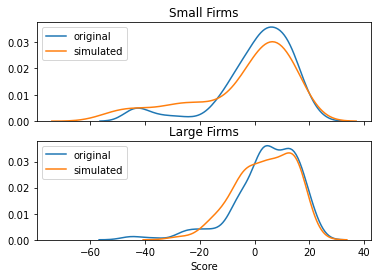

In [6]:
# plot scores of original and simulated data
fig, ax = plt.subplots(2, 1, sharex=True)
for size, number in [("Small Firms", 0), ("Large Firms", 1)]:
    ax[number].set_title(size)
    ax[1].set_xlabel("Score")
    sns.kdeplot(original_data.loc[original_data["largem"]==number, "s"], ax=ax[number], label="original")
    sns.kdeplot(simulated_data.loc[simulated_data["large"]==number, "score"], ax=ax[number], label="simulated")

In the original paper, the authors run polynomial regressions with $P \in \{0, 1, 2, 3\}$ and choose the optimal model according to the AIC which is readily available when running a linear regression. They find that there is no treatment effect for the large firms (see Table 5 Panel A left hand side in their paper). The dependent variable $Y$ (total investment in R&D divided by pre-program sales) I now create according to the following true data generating process:

\begin{equation}
    \begin{split}
        P &= 1 \\
        \alpha_{1p} &= (-0.05, -0.0016)' \\
        \alpha_{2p} &= (0, 0)' \\
        \beta_{1p} &= (0.08, 0.0003)' \\
        \beta_{2p} &= (0, 0)'.
    \end{split}
\end{equation}

This means that the true data generating process prescribes that for large firms there is no effect at all of the score on $Y$ and hence also no treatment effect. The dependent variable fluctuates randomly around 0. This is also what was found by the authors. The coefficients for small firms are also inspired by the authors' results when running a first order polynomial regression on the true data. The treatment effect for small firms is equal to 0.08 while score generally has an order one polynomial effect on $Y$. This data generating process results in the following typical RDD representation of the data in which $Y$ is plotted on the assignment variable $X$. Additionally, as the authors, I present this here only for small firms and average over $Y$ for each score.

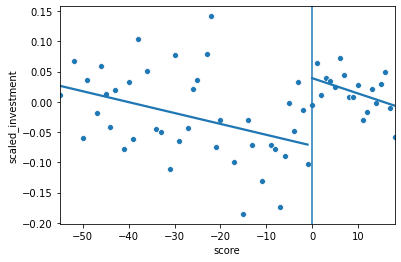

In [7]:
# plot small firms averaged scaled investment on the score (from previously simulated data)
small = simulated_data.loc[simulated_data["large"] == 0, :]
mean_small = small.groupby("score").mean()
mean_small.reset_index(inplace=True)
fig, ax = plt.subplots()
sns.scatterplot(mean_small["score"], mean_small["scaled_investment"], ax=ax)
ax.axvline()
sns.regplot(mean_small.loc[mean_small["score"]<0, "score"], mean_small.loc[mean_small["score"]<0, "scaled_investment"],
           order=1, scatter=False, ci=None)
sns.regplot(mean_small.loc[mean_small["score"]>=0, "score"], mean_small.loc[mean_small["score"]>=0, "scaled_investment"],
           order=1, scatter=False, ci=None, color=sns.color_palette("tab10")[0])

The error term is postulated as clustered by the authors (which is also assumed for the figure above). In my simulations, I control for different possible distributions of the error term. I show them graphically below. The homoskedastic is a $0.08 \times N(0, 1)$ distribution. The "normal" one is heteroskedastic in the sense that the error increases the closer the score is to the cutoff. In the "inverse" case this heteroskedasticity pattern is flipped around. In the "random_cluster" scenario I cluster the standard erros by allowing the error to come from a different uniform distribution centered around zero depending on the score and I add it to $0.05 \times N(0,1)$. The resulting error distributions are presented below.

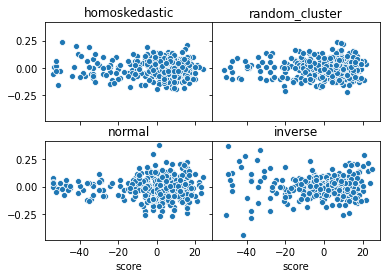

In [8]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, gridspec_kw={"wspace": 0})
for error_distr in [("homoskedastic", 0, 0), ("random_cluster", 0, 1) ,("normal", 1, 0), ("inverse", 1, 1)]:
    data, error = simulate_data(num_obs, coefficients, error_dist=error_distr[0])  
    sns.scatterplot(data["score"], error, ax=ax[error_distr[1], error_distr[2]])
    ax[error_distr[1], error_distr[2]].set_title(error_distr[0])

In my simulation I now estimate the model using different functional forms and approaches. I always correctly exclude any regressors for large firms and only include different polynomials for the small firms. I run the polynomial regressions above with $P \in \{0, 1, 2, 3\}$ for small firms. Additionally, I separately extract which model would be selected when using the AIC. On top of that, I run Jackknife Model Averaging on the simulated data set as well. For the Jackknife Model Averaging I allow the procedure to average over the four different $P$. For each simulation run I report the estimated treatment effect, indicate whether the 95 percent confidence interval covers the true treatment effect parameter and how wide the confidence interval is. This is done for 1000 runs. The confidence interval for the polynomial regressions is readily available and consequently so is the one for the AIC model selection case. For JMA, per run, I bootstrap from the simulated data set 200 times by drawing with replacement and running JMA for the newly created data to obtain a confidence interval for the treatment effect. I opt for the simple percentile confidence interval (compare chapter 5 in Davidson and Hinkley (1997)). 
In the next step I average the treatment effect over the 1000 runs, calculate the standard deviation and the root mean squared error to observe how well the different approaches recover the true treatment effect. Further I report the coverage probability and average width of the confidence interval to get a picture of how inference might be flawed and how large the increase in width should be to obtain good coverage. 

I choose the order one polynomial model as the true underlying data generating process to see how JMA reacts to the unfavourable condition of having to face more flexible specifications which are not actually the true ones. As the true model is among the models to average over, though, the average treatment effect should converge to the true treatment effect with increasing number of observations (firms in the sample). This root-n consistency I check by running the above 1000 runs with different number of observations $N \in \{100, 200, 360, 600, 1000\}$. Generally, I expect the AIC to perform better in recovering the treatment effect as the true model is among the candidates and as opposed to JMA, the AIC does not confound it with the others when it is selected. In this situation where the number of observations is still somewhat small, JMA should have problems as it could easily find higher order effects of score in every run due to random disturbances (error term) which causes the bias to be quite substantial as the true linear form is confounded by higher order polynomials. 
At the same time I expect the JMA confidence interval to have good coverage of the true treatment effect outperforming the AIC model selection due to its incorporation of model uncertainty. As opposed to Button (2016), I allow the error term not to be homoskedastic. As JMA is supposed to be robust to heterskedasticity, I do not expect large differences in performance across different error term specifications. The existence of heteroskedasticity gives an edge for JMA in comparison to the other model averaging procedures considered in Button (2016) as they are not heteroskedasticity robust (see Hansen and Racine (2012)). Button should have included a simulation with heteroskedasticity but this is only a side remark. I run the previously described simulation below.

In [7]:
# If we are running on TRAVIS-CI we will simply load a file with existing results.
# just load the results after if statement if the simulation might take too long for you (I had to run it over night)...
if os.environ.get("TRAVIS"):
    results_linear_dgp = pickle.load(open("data/simulated/results_linear.pickle", "br"))
    processed_results_linear_dgp = pickle.load(
        open("data/simulated/processed_results_linear.pickle", "br"))                                        
else:
    # set up simulations
    np.random.seed(123)
    num_runs = 1000
    num_bootstrap_runs = 200
    true_treatment_effect = 0.08
    true_model = {
        "polynomials": 1,
        "coefficients": {
            "untreated": np.array([-0.05, -0.0016]),
            "treated": np.array([0.08, 0.0003]),
        },
    }
    # run simulations                                                
    results_linear_dgp = {}
    processed_results_linear_dgp = {}
    for error_distr in ["homoskedastic", "random_cluster" ,"normal", "inverse"]:
        results_linear_dgp[error_distr] = {}
        processed_results_linear_dgp[error_distr] = {}
        for num_obs in [100, 200, 360, 600, 1000]:
            results_linear_dgp[error_distr][str(num_obs)] = get_results_regression(
                num_runs, num_obs, num_bootstrap_runs, true_model, error_distr
            )
            processed_results_linear_dgp[error_distr][str(num_obs)] = process_results(
                results_linear_dgp[error_distr][str(num_obs)], true_treatment_effect
            )

Below I present the results of this simulation for the run in which I postulate the situation as in the paper. In the paper, $N$ equals to 360 and the error terms are assumed to be clustered across scores. In the other specifications with different error terms and sample sizes, the qualitative conclusion that I will make below stay valid which is way I do not present all the results here. 

As expected the bias for JMA is larger than the one for model selection using AIC. Overall, though, JMA has a lower root mean squared error which is achieved by a reduction of the standard error of the estimated treatment effect. We can further see that the coverage probability of the 95 percent confidence interval almost reaches its nominal level while for AIC it is around nine percent below it. Rejection of the null hypothesis that the treatment effect equals zero in the case of AIC actually has a higher risk of type I error than the researcher nominally expects. This is different for JMA and in this specific example, a test would even be more conservative as the treatment effect is underestimated. The better coverage is obviously achieved for JMA by wider confidence intervals which compensate for the fact that the bias is generally larger. As a side remark it should be noted, that for the case of an "inverse" error, the bias encountered by JMA is larger than for the other cases which can be explained by the fact, that generally the error can be stronger than in other specifications (which can be seen in my figure with the different error distributions). This likely induces the JMA to find an influence of higher order polynomials more often which makes the confounding effect stronger.

In [10]:
processed_results_linear_dgp["random_cluster"]["360"]

,AIC,JMA,polynomial_0,polynomial_1,polynomial_2,polynomial_3
Statistic,,,,,,
Treatment Effect,0.078921,0.071887,0.033971,0.080486,0.080926,0.081253
Bias,-0.001079,-0.008113,-0.046029,0.000486,0.000926,0.001253
Standard Error,0.028744,0.025121,0.011654,0.020865,0.028149,0.036208
RMSE,0.028764,0.026399,0.047482,0.020871,0.028164,0.036230
95% Coverage,0.859000,0.944000,0.037000,0.946000,0.942000,0.940000
CI Width,0.082082,0.107835,0.048016,0.078485,0.105812,0.135816


The root-n consistency I check, as suggested in Zhang (2015), by calculating $N^{0.95} \times MSE$. For root-n consistency we should see that with increasing $N$ the above measure should decrease. This is presented below again for "random_cluster" error term but generalizes across other error specifications.

In [12]:
consistency = pd.DataFrame(index=["AIC", "JMA"], columns=[100, 200, 360, 600, 1000])
for num_obs in [100, 200, 360, 600, 1000]:
    consistency[[num_obs]] = processed_results_linear_dgp[
        "random_cluster"][str(num_obs)].loc["RMSE", ["AIC", "JMA"]].to_numpy().reshape((2, 1))**2 * num_obs**0.95
consistency

,100,200,360,600,1000
AIC,0.286025,0.25876,0.221922,0.202671,0.179699
JMA,0.179326,0.188912,0.18692,0.177417,0.1622


The theoretical result which is proven by Zhang (2015) for JMA seems to be confirmed in my simulation. It appears that $1000$ simulation runs are not sufficiently many runs to show this consistently from $N$ equal to 100 onwards but rather I obtain it solely from $N=200$ onwards. Although not proven by Zhang (2015) but maybe somewhere else, root-n consistency seems to hold for AIC model selection in my example.

I adapt the previous simulation study now such that the true data generating process is actually a fourth order polynomial. The coefficients now are the following:

\begin{equation}
    \begin{split}
        P &= 4 \\
        \alpha_{1p} &= (-0.05, -0.00016, -0.00006, -5e^{-6}, -5e^{-8})' \\
        \alpha_{2p} &= (0, 0)' \\
        \beta_{1p} &= (0.08, 0.00002, 0.00009, -8e^{-6}, -8e^{-8})' \\
        \beta_{2p} &= (0, 0)'.
    \end{split}
\end{equation}

In order to estimate the treatment effect, I run now the same Monte Carlo simulation as above with only the data generating process having changed. This means that the true model is now not among those considered in my estimation strategy anymore. The theoretical consistency proven by Zhang (2015) does not hold in this scenario. I want to check if we can still find it in practice, though, with this rather mild deviation of the largest model considered from the true data generating process. Further I want to check whether the difference in bias between AIC and JMA stays equally large or whether JMA catches up to AIC or might be even better as now confounding because of overfitting is not an issue anymore. JMA might be expected to even outperform AIC as JMA will likely always add some information from the "best" model which is the third order polynomial. AIC on the other hand will likely choose some other orders sometimes which leads to loss of information and stronger bias as when some information from the third order was included. Lastly, I want to see if the coverage probability for JMA stays higher and close to the nominal level, although now the true model is outside the space of those considered. Before we run the simulation study, let us have a look how the averaged dependent variable relates to the assignment variable for small firms now (again for $N=360$ and clustered error terms). 

In [11]:
# simulate data
np.random.seed(123)
num_obs = 360
polynomials = 4
coefficients = {
    "untreated": np.array([-0.05, -0.00016, -0.00006, -5e-6, -5e-8]),
    "treated": np.array([0.08, 0.00002, 0.00009, -8e-6, -8e-8])}
simulated_data = simulate_data(num_obs, coefficients, polynomials, error_dist="random_cluster")[0]

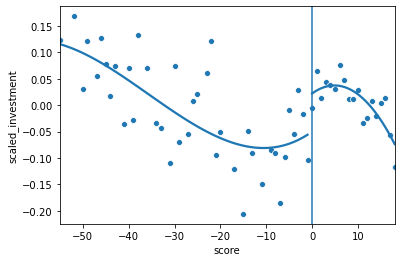

In [12]:
# plot small firms averaged scaled investment on the score
small = simulated_data.loc[simulated_data["large"] == 0, :]
mean_small = small.groupby("score").mean()
mean_small.reset_index(inplace=True)
fig, ax = plt.subplots()
sns.scatterplot(mean_small["score"], mean_small["scaled_investment"], ax=ax)
ax.axvline()
sns.regplot(mean_small.loc[mean_small["score"]<0, "score"], mean_small.loc[mean_small["score"]<0, "scaled_investment"],
           order=3, scatter=False, ci=None)
sns.regplot(mean_small.loc[mean_small["score"]>=0, "score"], mean_small.loc[mean_small["score"]>=0, "scaled_investment"],
           order=3, scatter=False, ci=None, color=sns.color_palette("tab10")[0])

It is clearly visible now that the effect is nonlinear, when fitting a cubic polynomial. We are now ready to run the described simulation below.

In [18]:
# If we are running on TRAVIS-CI we will simply load a file with existing results.
# just load the results after if statement if the simulation might take too long for you (I had to run it over night)...
if os.environ.get("TRAVIS"):
    results_nonlinear_dgp = pickle.load(open("data/simulated/results_nonlinear.pickle", "br"))
    processed_results_nonlinear_dgp = pickle.load(open(
        "data/simulated/processed_results_nonlinear.pickle", "br"))                                        
else:
    # set up simulation
    np.random.seed(123)
    num_runs = 1000
    num_bootstrap_runs = 200
    true_treatment_effect = 0.08
    true_model = {
        "polynomials": 4,
        "coefficients": {
            "untreated": np.array([-0.05, -0.00016, -0.00006, -5e-6, -5e-8]),
            "treated": np.array([0.08, 0.00002, 0.00009, -8e-6, -8e-8]),
        },
    }
    # run simulation
    results_nonlinear_dgp = {}
    processed_results_nonlinear_dgp = {}
    for error_distr in ["homoskedastic", "random_cluster" ,"normal", "inverse"]:
        results_nonlinear_dgp[error_distr] = {}
        processed_results_nonlinear_dgp[error_distr] = {}
        for num_obs in [100, 200, 360, 600, 1000]:
            results_nonlinear_dgp[error_distr][str(num_obs)] = get_results_regression(
                num_runs, num_obs, num_bootstrap_runs, true_model, error_distr
            )
            processed_results_nonlinear_dgp[error_distr][str(num_obs)] = process_results(
                results_nonlinear_dgp[error_distr][str(num_obs)], true_treatment_effect
            )

Below I shortly present the examplary case of $N=360$ and clustered errors. What is interesting to see here is that the actual coverage probablity of JMA is higher than for any of the single models and that it still corresponds to its nominal level leaving AIC clearly behind. Also, here, JMA seems to also perform better than AIC looking at the bias for this specific case. 

In [14]:
processed_results_nonlinear_dgp["random_cluster"]["360"]

,AIC,JMA,polynomial_0,polynomial_1,polynomial_2,polynomial_3
Statistic,,,,,,
Treatment Effect,0.075707,0.080547,0.014510,0.127161,0.071150,0.076685
Bias,-0.004293,0.000547,-0.065490,0.047161,-0.008850,-0.003315
Standard Error,0.034648,0.032097,0.013089,0.021502,0.028219,0.036201
RMSE,0.034913,0.032102,0.066785,0.051832,0.029575,0.036352
95% Coverage,0.863000,0.952000,0.001000,0.390000,0.926000,0.936000
CI Width,0.107287,0.124099,0.055363,0.081085,0.105990,0.135847


To get a better picture, though, of how JMA and AIC actually perform here, let us compare the clustered arror case across different sample sizes. In the table below I present how the treatment effect and the coverage probability develops with increasing $N$ and whether there is any root-n consistency.

In [15]:
statistics = ["Treatment Effect", "root-n MSE", "95% Coverage"]
approaches = ["AIC", "JMA"]
index = pd.MultiIndex.from_product([statistics, approaches], names=["Statistic", "Approach"])
consistency = pd.DataFrame(index=index, columns=[100, 200, 360, 600, 1000])
for num_obs in [100, 200, 360, 600, 1000]:
    consistency.loc["root-n MSE", num_obs] = processed_results_nonlinear_dgp[
        "random_cluster"][str(num_obs)].loc["RMSE", ["AIC", "JMA"]].to_numpy().reshape((2, 1))**2 * num_obs**0.95
    consistency.loc[["Treatment Effect", "95% Coverage"], num_obs] = processed_results_nonlinear_dgp[
        "random_cluster"][str(num_obs)].loc[["Treatment Effect", "95% Coverage"], ["AIC", "JMA"]].to_numpy().reshape(4, 1)
consistency

100        200        360        600   \
Statistic        Approach                                               
Treatment Effect AIC       0.0912693   0.080805  0.0757073  0.0717522   
                 JMA       0.0847633  0.0823432  0.0805469  0.0759521   
root-n MSE       AIC        0.406662   0.378382   0.326926   0.307912   
                 JMA          0.2663   0.280669   0.276411   0.270257   
95% Coverage     AIC           0.733      0.808      0.863      0.898   
                 JMA            0.95      0.946      0.952       0.94   

                                1000  
Statistic        Approach             
Treatment Effect AIC       0.0730202  
                 JMA       0.0756255  
root-n MSE       AIC        0.316256  
                 JMA        0.276823  
95% Coverage     AIC           0.898  
                 JMA           0.938

We can see for treatment effect and $N^{0.95} \times MSE$, that for both approaches no clear convergence can be found. In this case, though, the treatment effect estimates of JMA seem to be more stable than those of AIC. Interestingly, the coverage probability of JMA decreases with larger sample size while it increases for AIC. Generally, JMA has again a coverage probability close to its nominal level outperforming AIC. Both of those findings are robust across the four different error distributions considered. For the other error distributions I also do not find any clear convergence pattern for treatment effect and the MSE criterion. For all four distributions, JMA performs on average a bit better than AIC regarding bias as it was expected.

Brought together this first simulation study shows that JMA outperforms AIC regarding coverage probability bringing the Type I error to its nominal level when testing for a nonzero treatment effect. Above that, the second part indicates that JMA seems to show a lower bias when the true model is not among those considered but one of the estimated models is rather close to the true one. This is a feature that might likely be found in RDD where a high order polynomial is often a good approximation of the true model but it probably is not exactly among those considered. This shows that JMA has some appealing features that might be useful to make the estimation of treatment effect and the following inference more reliable in comparison to the usually employed model selection based on the AIC.

## Simulation Study Two

As noted in my introduction, it is common practice in RDD to rather run local linear regressions to determine the best bandwidth around the cutoff instead of solely estimating polynomial regressions across the whole bandwidth. This is motivated by the intuitive notion that as one is interested in the difference in $Y$ close to the cutoff one should also only rely on data close to it. As described in the section on RDD, Imbens and Lemieux (2008) suggest a bandwidth selection that is based on a cross validation criterion which is supposed to approximate the expected test mean squared error across different bandwidths based on local linear regressions. The approach of Hansen and Racine (2012) has also the objective to approximate the expected test MSE with their least squares cross validation criterion. This observation induces me to try whether JMA and its criterion might be used to determine the optimal bandwidth allowing to average over polynomials of higher order than just running a regression with poylnomial of order (as done with local linear regressions). Hansen and Racine (2012) argue that their approach can serve for local polynomial regressions with fixed bandwidth while I want to go beyond it suggesting that it can even choose the bandwidth. As the linear regression is part of the models the JMA averages over, I expect the JMA approach to at least perform as well as the linear approach when the linear approximation is at least imperfect based on the observations from the previous simulation study. 

My idea is that the approach could even perform better when there is a clear indication that the effect of the assignment variable is not linear locally around the cutoff (Imbens and Lemieux (2008) justify their approach by arguing that the linear approximation is typically a good one locally). In Bronzini and Iachini (2014), the authors opt for a sole robustness check based on a nonlinear kernel estimation for two fixed bandwidths, $h \in \{15, 30\}$. This indicates that also the authors did not necessarily believe in a good linear approximation locally. On the other hand, the fact that it is only a robustness check, though, displays that the setup in which they are is not typically well-suited for nonparametric methods such as local linear regressions. The reason is given by Lee and Lemieux (2010) who argue that RDD with discrete assignment variables (on top of that with a small sample, here) do not yield a good foundation for local methods as the amount of data around the cutoff is rather low. As I do not want to introduce another data generating process (due to size constraints) I run a comparison between local linear regression and JMA for bandwidth selection based on the setup in Bronzini and Iachini (2014) anyways with the idea of a good performance in this setup a good performance in more favourable setups should follow. I tested at which minimum bandwidth the resulting estimated treatment effects are reasonable and found that $h=10$ works well. Consequently, I run a bandwidth selection where I consider all integer bandwidths between 10 and 35. I add five more integers to each side of the bandwidths considered by Bronzini and Iachini. Again I run 1000 simulations in which I first simulate a data set with the same data generating process as in the last simulation, i.e. with $P=4$. Then I run local linear regressions as suggested in Imbens and Lemieux (2008) as well as JMA as specified before across all bandwidths. This yields the respective criterion per approach and per bandwidth among which I choose the bandwidth with the smallest criterion value. No matter which approach selected the bandwidth, I then estimate the treatment effect with JMA to not confound the results by using different estimation techniques for the treatment effect. For every run I report which bandwidth was selected, what the minimum of the criterion is, how high the estimated treatment effect is and how long it took to find the optimal bandwidth. As the effect of score on scaled investment is nonlinear and this seems to also persist locally (when looking abck at my figure of the last simulation), I expect JMA to be at least as good as local linear regressions in selecting the optimal bandwidth. 

The main reason I added the different error distributions is for this second simulation study. I want to observe if JMA can follow local linear regressions with good selection across different specifications. In the inverse case one expects that both approaches should select a bandwidth close to the smallest possible ($h_{min}=10$) as the error is small there. For the "normal" case this should be the other way around. For homoskedasticity and especially for the clustered case I hope to obtain many different choices of bandwidth as the random error distribution across scores lets the effect of score appear more or less linear across scores. JMA might exploit the high order polynomials sometimes where the expected test MSE for the local linear regression is not the lowest due to an imperfect linear approximation for instance. I run the described simulation below.

In [33]:
# If we are running on TRAVIS-CI we will simply load a file with existing results.
# just load the results after if statement if the simulation might take too long for you (I had to run it over night)...
if os.environ.get("TRAVIS"):
    results_local = pickle.load(open("data/simulated/results_local.pickle", "br"))
    processed_results_local = pickle.load(
        open("data/simulated/processed_results_local.pickle", "br"))                                        
else:
    # set up simulation 
    np.random.seed(123)
    num_runs = 1000
    num_obs = 360
    start_local = 10
    start_jma = 10
    width = 35
    true_model = {
        "polynomials": 4,
        "coefficients": {
            "untreated": np.array([-0.05, -0.00016, -0.00006, -5e-6, -5e-8]),
            "treated": np.array([0.08, 0.00002, 0.00009, -8e-6, -8e-8]),
        },
    }
    subset = np.array([np.arange(2), np.arange(4), np.arange(6), np.arange(8)])
    true_treatment_effect = 0.08
    
    # run simulation
    results = {}
    processed_results = {}
    for error_dist in ["homoskedastic", "random_cluster" ,"normal", "inverse"]:
        results[error_dist] = get_results_local_regression(
            num_runs,
            num_obs,
            true_model,
            start_local,
            start_jma,
            width,
            subset,
            error_dist=error_dist,
        )
        processed_results[error_dist] = process_results_local(
                results[error_dist], true_treatment_effect
            )

The results from the above simulation are processed such that I can present the average treatment effect, bias, standard error, mean squared error, expected MSE (according to the criterion of the approach), time, bandwidth and the percentage of times both approaches chose the same bandwidth. These processed results are shown below for all different error distributions.

In [17]:
# show results
for error_dist in ["homoskedastic", "random_cluster" ,"normal", "inverse"]:
    display(error_dist)
    display(processed_results_local[error_dist])

'homoskedastic'

,Treatment Effect,Bias,Standard Error,MSE,Expected MSE,Time,Same Bandwidth,Bandwidth
JMA,0.078796,-0.001204,0.020181,0.000409,0.006265,0.747767,0.617,16.784
local linear,0.079480,-0.000520,0.019133,0.000366,0.006415,3.125081,0.617,16.941


'random_cluster'

,Treatment Effect,Bias,Standard Error,MSE,Expected MSE,Time,Same Bandwidth,Bandwidth
JMA,0.079207,-0.000793,0.021904,0.000480,0.005906,0.743843,0.611,16.818
local linear,0.079815,-0.000185,0.020579,0.000424,0.006084,3.125983,0.611,16.965


'normal'

,Treatment Effect,Bias,Standard Error,MSE,Expected MSE,Time,Same Bandwidth,Bandwidth
JMA,0.078088,-0.001912,0.025937,0.000676,0.008272,0.748410,0.767,33.006
local linear,0.078358,-0.001642,0.025119,0.000634,0.008485,3.128192,0.767,32.404


'inverse'

,Treatment Effect,Bias,Standard Error,MSE,Expected MSE,Time,Same Bandwidth,Bandwidth
JMA,0.078474,-0.001526,0.013493,0.000184,0.00427,0.750192,0.978,10.029
local linear,0.078488,-0.001512,0.013525,0.000185,0.00429,3.115280,0.978,10.035


We can see that indeed for the "normal" and the "inverse" case the frequency of equal bandwidths chosen is the highest. As expected both approaches choose small bandwidth for the "inverse" and large bandwidth for the "normal" error distribution. Apart from that both approaches give very similar results for the treatment effect across all distributions while the local linear regression approach is slightly better. Despite that for homoskedastic and clustered errors only in around 60 percent of the cases the same bandwidth is chosen, the average bandwidth for both approaches is very similar. Unfortunately, within my already nonlinear example, the local linear approximation seems to work reasonably well such that JMA cannot improve the results. At the same time, we can also see that JMA does not do harm here neither which might still underline its strength by being as performant as local linear regressions while displaying more flexibility regarding rather nonlinear relations. It would be interesting to see how JMA reacts when the underlying data generating process is actually linear. Even more interesting might be whether one can come up with an example that is locally nonlinear such that it actually outperforms the linear approach. As my simulations are already long I have to conclude with my last simulation, though, and maybe come back to that in a future project. As a side remark for this last simulation it is worth noting that the efficient way of performing leave one out cross validation for linear regressions based on Hansen and Racine (2012) makes the approach way faster than the local linear regression in which I coded up the cross validation conventionally.

One should mention, though, that despite the fact that the assignment variable is discrete, the local approaches work well and Bronzini and Iachini should have performed a proper bandwidth selection as opposed to simply selecting two bandwidths as a robustness check and arguing with non-local polynomial regressions selected via AIC as their main results. This can be seen by the fact how well both local approaches recover the true treatment effect here in comparison to the same data generating process estimated via polynomial regressions before. Further it would have given them more credibility as only more local data around the cutoff is used. 

## Conclusion

My project shows that the typical method of choosing the optimal order of polynomial for the assignment variable in RDD based on model selection via AIC leads to too optimistic certainty of the estimated treatment effect. This results in clearly understated type I error. Jackknife Model Averaging can be a valid alternative in that regard as it appears that the confidence intervals reach their nominal coverage irrespective of whether the correct model is among those averaged over. At the same time, the bias encountered by AIC and JMA is similar when the true model is not among those considered by the researcher but at least one of the models is a good aproximation of the true one. This can be imagined to be a typical situation in RDD when deciding on the poylnomial order of the assignment variable. With this in mind, JMA should maybe be even the prefered approach. 

The second finding of my project is that without relying on theory but solely on my simulation evidence, JMA seems to be an alternative to local linear regressions for bandwidth selection in RDD. I show that when the true model is not among the candidates (but one considered model is a good proxy) and the effect of the assignment variable is generally nonlinear, JMA yields very similar results to the local linear approach and both can recover the true treatment effect quite well on average. Although not shown, I argue that it could be imagineable to find situations in which JMA might be even prefered over the local linear approach. I imagine such a situation to involve considerable nonlinearity locally that potentially varies a lot with the selected bandwidth.

### References


Bronzini, R., & Iachini, E. (2014). Are incentives for R&D effective? Evidence from a regression discontinuity approach. *American Economic Journal: Economic Policy, 6*(4), 100-134.

Button, P. (2016). Model uncertainty and model averaging in regression discontinuity designs. *Journal of Econometric Methods, 5*(1), 103-116.

Davison, A. C. and D. V. Hinkley (1997). Bootstrap Methods and their Application. Cambridge Series in Statistical and Probabilistic Mathematics. Cambridge University Press.

Fletcher, D. (2019). Model Averaging. Springer.

Hansen, B. E., & Racine, J. S. (2012). Jackknife model averaging. *Journal of Econometrics, 167*(1), 38-46.

Imbens, G. W., & Lemieux, T. (2008). Regression discontinuity designs: A guide to practice. *Journal of econometrics, 142*(2), 615-635.

Lee, D. S., & Lemieux, T. (2010). Regression discontinuity designs in economics. *Journal of economic literature, 48*(2), 281-355.

Li, K. C. (1987). Asymptotic optimality for Cp, CL, cross-validation and generalized cross-validation: discrete index set. *The Annals of Statistics, 958-975*.

Moral‐Benito, E. (2015). Model averaging in economics: An overview. *Journal of Economic Surveys, 29*(1), 46-75.

Steel, M. F. (forthcoming). Model Averaging and Its Use in Economics. *Journal of Economic Literature*.

Stone, M. (1974). Cross‐validatory choice and assessment of statistical predictions. *Journal of the Royal Statistical Society: Series B (Methodological), 36*(2), 111-133.

Wolpert, D. H. (1992). Stacked generalization. *Neural networks, 5*(2), 241-259.